# CLIP + ImageNet 训练主流程

本笔记本复用你刚实现的 ImageNet 数据加载器与 CLIP 训练脚本，完整演示：
- 数据加载 (Data Loading)
- 数据展示 (Visualization)
- 模型加载 (Model Setup)
- 模型训练 (Training)

并在每一步提供对应的理论与 LaTeX 推导说明。

## 1. 环境与导入

### 1.1 可重复性 (Reproducibility)
给定随机种子 $s$，随机序列由确定性函数 $\mathcal{R}$ 生成：
$$
\mathcal{R}_s(i) = f(i, s)
$$
在固定 $s$ 时，Python/NumPy/PyTorch 的伪随机序列保持一致，从而使实验可复现。

In [9]:
import os, sys, json, math, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 本目录下的模块
from imagenet_dataset import create_imagenet_dataloaders
import importlib, train_clip_imagenet
importlib.reload(train_clip_imagenet)
from train_clip_imagenet import set_seed, CLIPClassifier, train, train_one_epoch, evaluate

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print(f'PyTorch: {torch.__version__}')
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

PyTorch: 2.6.0+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. 数据加载 (Data Loading)

### 2.1 理论说明
给定训练集 $\mathcal{D}_{\text{train}}$ 与验证集 $\mathcal{D}_{\text{val}}$，经验风险最小化 (ERM) 目标为：
$$
\hat{\boldsymbol{\theta}} = \arg\min_{\boldsymbol{\theta}} rac{1}{N} \sum_{i=1}^{N} \mathcal{L}ig(f_{\boldsymbol{\theta}}(\mathbf{x}_i), y_iig)
$$

CLIP 模型要求输入大小 $224\times224$，且采用固定的归一化参数 $\boldsymbol{\mu}, \boldsymbol{\sigma}$：
$$\tilde{\mathbf{x}} = (\mathbf{x} - \boldsymbol{\mu}) / \boldsymbol{\sigma}$$
其中 $\boldsymbol{\mu}=(0.4814,0.4578,0.4082),\; \boldsymbol{\sigma}=(0.2686,0.2613,0.2758)$。
当没有独立的 val 目录时，我们从 train 按比例切分一部分用作验证集。

In [3]:
# 配置
SEED = 42
DATA_ROOT = r'g:/Thomas/3_1_project/data/ImageNet-data'
BATCH_SIZE = 32
NUM_WORKERS = 0  # Windows建议0
NUM_CLASSES = 10  # 使用前N个类别
IMAGE_SIZE = 224
VAL_SPLIT = 0.1  # 无val目录时，从train划分比例

set_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('使用设备:', device)

# 创建DataLoader（内部已与CLIP预处理对齐）
train_loader, val_loader = create_imagenet_dataloaders(
    root=DATA_ROOT,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    num_classes=NUM_CLASSES,
    image_size=IMAGE_SIZE,
    use_clip_norm=True,
    seed=SEED,
    val_split=VAL_SPLIT,
)

print(f'训练批次数: {len(train_loader)}')
print(f'验证批次数: {len(val_loader)}')

使用设备: cuda
✓ 加载 train 集: 12771 张图像, 10 个类别
⚠ 未找到独立的val目录，从训练集中分割 10% 作为验证集
  训练集: 11494 样本
  验证集: 1277 样本
训练批次数: 360
验证批次数: 40


## 3. 数据展示 (Visualization)

为了直观检查预处理效果，我们将对批数据进行反归一化：
$$\mathbf{x}_{\text{vis}} = \tilde{\mathbf{x}} \odot \boldsymbol{\sigma} + \boldsymbol{\mu}$$

训练样本预览:


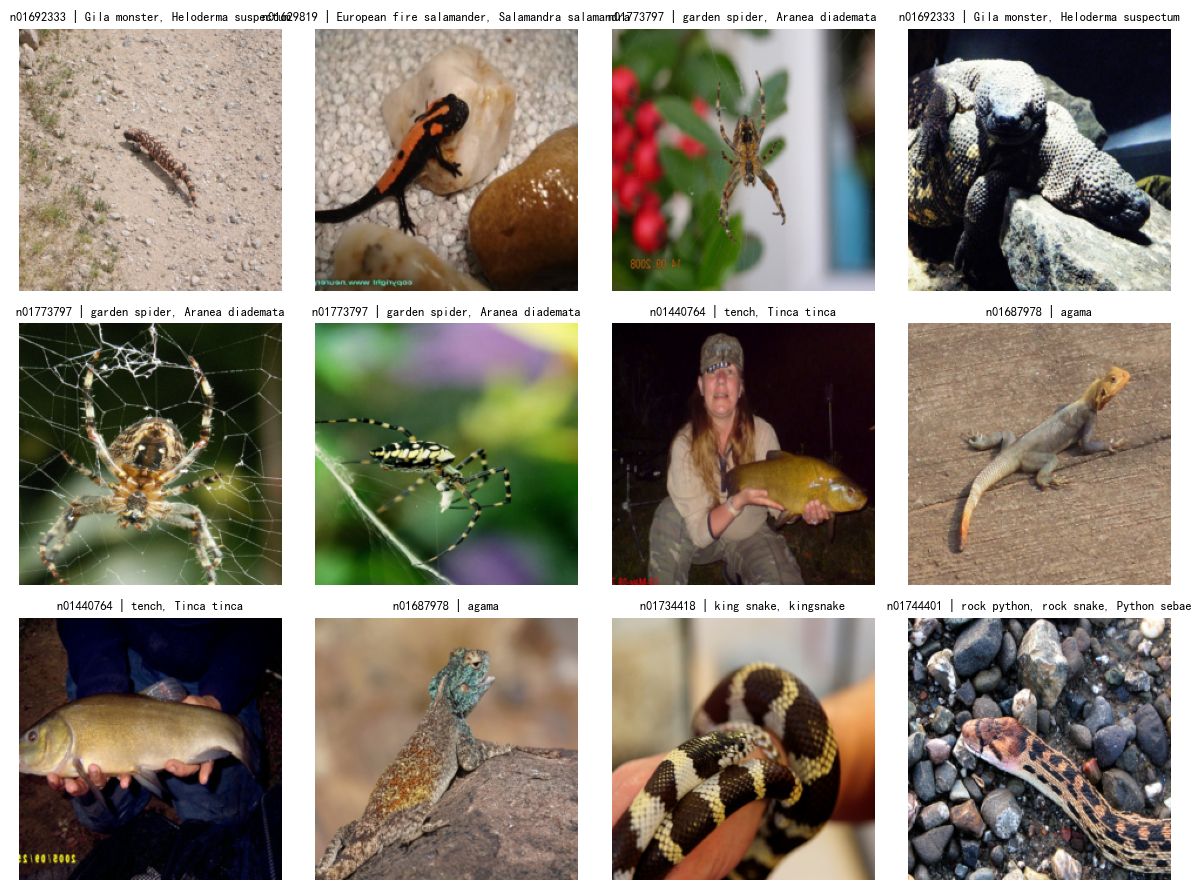

验证样本预览:


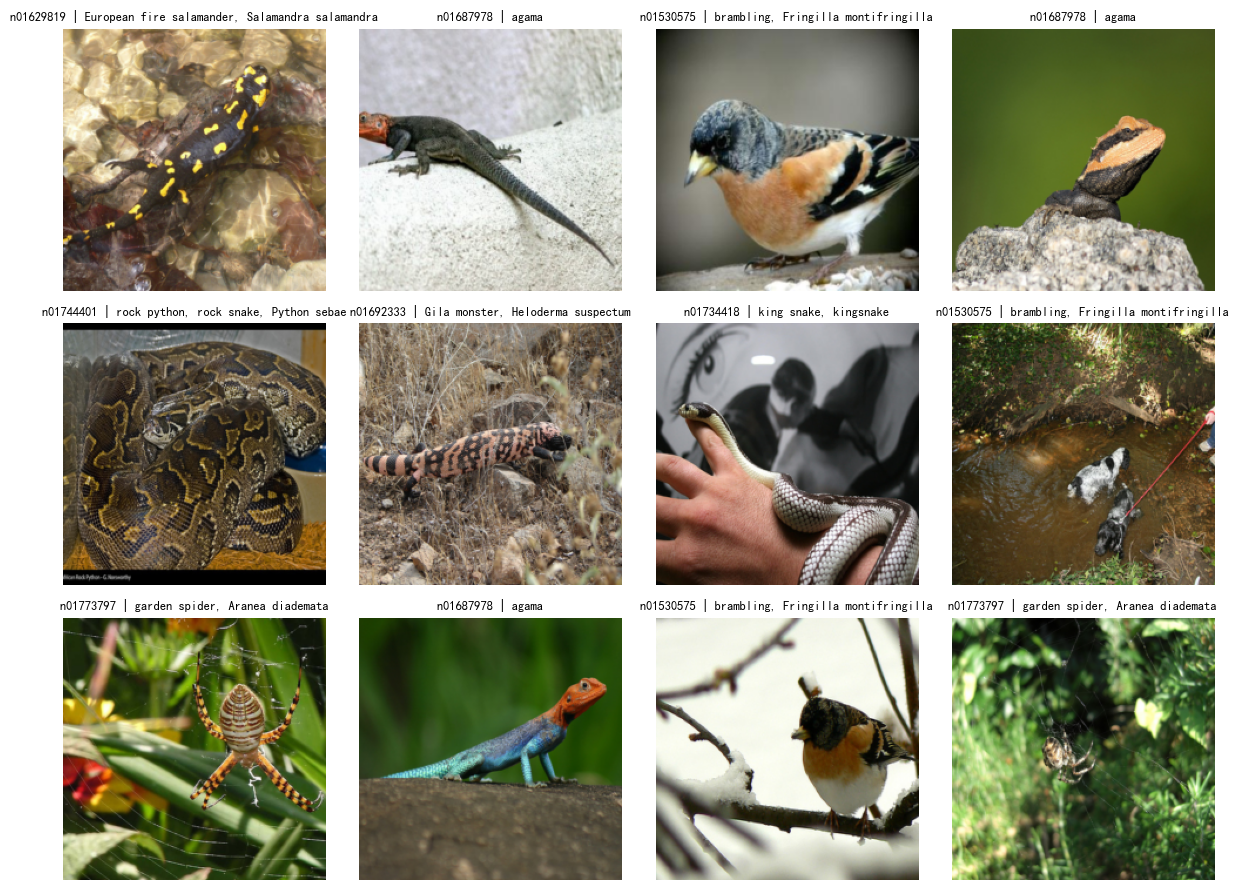

In [5]:
import torch

def denorm_clip(x):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1,3,1,1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1,3,1,1)
    if x.dim()==3:
        mean, std = mean.squeeze(0), std.squeeze(0)
    return torch.clamp(x*std + mean, 0, 1)

def show_batch(dataloader, num_images=12, cols=4):
    images, labels = next(iter(dataloader))
    images_vis = denorm_clip(images.clone())
    rows = (num_images+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    base = dataloader.dataset
    if hasattr(base, 'dataset'): base = base.dataset  # 处理Subset
    for i in range(min(num_images, images.size(0))):
        img = images_vis[i].permute(1,2,0).numpy()
        label = labels[i].item()
        wnid = base.get_wnid(label)
        name = base.get_class_name(label)
        axes[i].imshow(img)
        axes[i].set_title(f'{wnid} | {name}', fontsize=9)
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()

print('训练样本预览:')
show_batch(train_loader, 12, 4)
print('验证样本预览:')
show_batch(val_loader, 12, 4)

## 4. 模型加载 (Model Setup)

### 4.1 结构说明
CLIP 视觉编码器 $f_{\text{img}}$ 输出特征 $\mathbf{z} \in \mathbb{R}^d$，线性头进行分类：
$$\hat{y} = \arg\max_k (\mathbf{W}\mathbf{z}+\mathbf{b})_k$$
其中 $d=512$ (ViT-B/32)。冻结编码器时仅优化 $\{\mathbf{W}, \mathbf{b}\}$。

In [10]:
CLIP_ARCH = 'ViT-B/32'
FREEZE_ENCODER = True

model = CLIPClassifier(num_classes=NUM_CLASSES, clip_arch=CLIP_ARCH, freeze_encoder=FREEZE_ENCODER, device=device)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'参数总量: {total:,} 可训练: {trainable:,} 比例: {100.0*trainable/total:.4f}%')

加载CLIP模型: ViT-B/32 ...
冻结CLIP视觉编码器参数
参数总量: 151,282,443 可训练: 5,130 比例: 0.0034%


## 5. 训练 (Training)

### 5.1 优化与调度
- 优化器 AdamW：
$$\boldsymbol{\theta}_t = \boldsymbol{\theta}_{t-1} - \eta \left( \frac{\hat{\mathbf{m}}_t}{\sqrt{\hat{\mathbf{v}}_t}+\epsilon} + \lambda\boldsymbol{\theta}_{t-1} \right)$$
- 余弦退火 CosineAnnealing：
$$\eta_t = \eta_{\min} + 	frac{1}{2}(\eta_{\max}-\eta_{\min})(1+\cos(\tfrac{t}{T_{\max}}\pi))$$

### 5.2 混合精度 (AMP)
使用 FP16 前向/反向 + FP32 权重，梯度缩放避免下溢：
$$\tilde{\mathbf{g}} = s\cdot\mathbf{g}_{16}, \; \Delta\boldsymbol{\theta} = -\eta 	frac{\tilde{\mathbf{g}}}{s}$$

In [11]:
# 方案A：直接调用高阶训练函数（包含AMP、增强、保存best.ckpt）
OUTPUT_DIR = './checkpoints'
EPOCHS = 3
LR = 1e-3
WEIGHT_DECAY = 1e-4
USE_AUG = True
USE_AMP = True

best_ckpt = train(
    data_root=DATA_ROOT,
    output_dir=OUTPUT_DIR,
    device=torch.device(device),
    arch=CLIP_ARCH,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    freeze_encoder=FREEZE_ENCODER,
    num_workers=NUM_WORKERS,
    class_subset=None,
    seed=SEED,
    use_amp=USE_AMP,
    use_aug=USE_AUG,
    val_split=VAL_SPLIT,
)
print('最佳模型:', best_ckpt)

✓ 加载 train 集: 13000 张图像, 10 个类别
⚠ 未找到独立的val目录，从训练集中分割 10% 作为验证集
  训练集: 11700 样本
  验证集: 1300 样本
加载CLIP模型: ViT-B/32 ...
冻结CLIP视觉编码器参数

开始训练 ...
Epoch 1/3


[Val]: 100%|██████████| 41/41 [00:21<00:00,  1.94it/s, acc=96.08%, loss=0.0924]


  174.3s | Train 0.5144/91.14% | Val 0.2027/96.08% | LR 0.000750
  ✓ 保存最佳模型 -> ./checkpoints\best_clip_imagenet_10cls.pth
Epoch 2/3


[Val]: 100%|██████████| 41/41 [00:11<00:00,  3.45it/s, acc=96.69%, loss=0.0640]


  124.5s | Train 0.1706/96.15% | Val 0.1520/96.69% | LR 0.000250
  ✓ 保存最佳模型 -> ./checkpoints\best_clip_imagenet_10cls.pth
Epoch 3/3


[Val]: 100%|██████████| 41/41 [00:12<00:00,  3.39it/s, acc=96.38%, loss=0.0494]

  136.7s | Train 0.1417/96.51% | Val 0.1471/96.38% | LR 0.000000
训练完成，最佳验证准确率: 96.69%
最佳模型: ./checkpoints\best_clip_imagenet_10cls.pth


### 5.3 载入最佳权重并评估
如果训练已完成，可以载入最佳权重并在验证集上评估。

In [13]:
# 载入最佳权重评估
ckpt_path = best_ckpt if 'best_ckpt' in globals() else os.path.join(OUTPUT_DIR, f'best_clip_imagenet_{NUM_CLASSES}cls.pth')
print('加载:', ckpt_path)
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state['state_dict'])
val_loss, val_acc = evaluate(model, val_loader, device, use_amp=USE_AMP)
print(f'验证集: Loss={val_loss:.4f} Acc={val_acc:.2f}%')

加载: ./checkpoints\best_clip_imagenet_10cls.pth


[Val]: 100%|██████████| 40/40 [00:10<00:00,  4.00it/s, acc=23.49%, loss=4.4354]

验证集: Loss=4.4999 Acc=23.49%


## 6. 预测可视化 (Predictions)
从验证集中取一批样本，展示预测与真值。

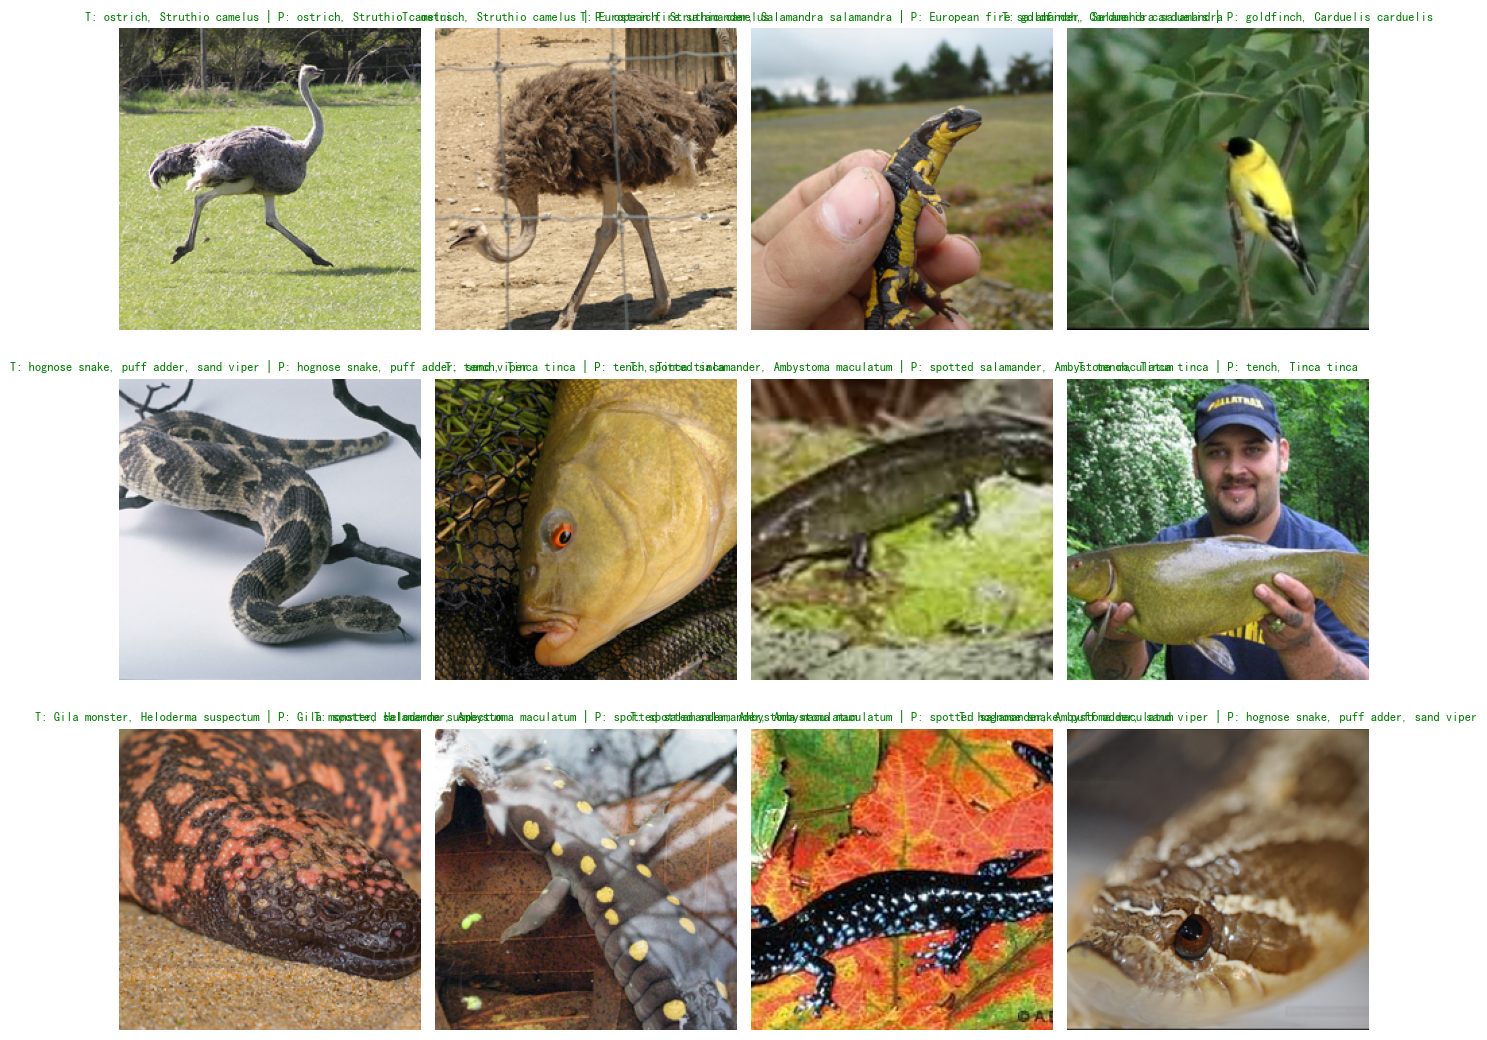

In [17]:
@torch.no_grad()
def show_predictions(model, dataloader, num_images=12, cols=4):
    model.eval()
    images, labels = next(iter(dataloader))
    images_gpu = images.to(device)
    logits = model(images_gpu)
    preds = logits.argmax(dim=1).cpu()
    base = dataloader.dataset
    if hasattr(base, 'dataset'): base = base.dataset
    rows = (num_images+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.6))
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    images_vis = denorm_clip(images.clone())
    for i in range(min(num_images, images.size(0))):
        img = images_vis[i].permute(1,2,0).numpy()
        t_lbl, p_lbl = labels[i].item(), preds[i].item()
        t_name = base.get_class_name(t_lbl)
        p_name = base.get_class_name(p_lbl)
        color = 'green' if t_lbl==p_lbl else 'red'
        axes[i].imshow(img)
        axes[i].set_title(f'T: {t_name} | P: {p_name}', color=color, fontsize=9)
        axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()

show_predictions(model, val_loader_eval, 12, 4)

In [18]:
# 调试：查看仍为可训练的参数统计与名称片段
trainable = [(n, p.numel()) for n,p in model.named_parameters() if p.requires_grad]
print('可训练参数个数:', len(trainable))
print('总可训练参数量:', sum(n for _, n in trainable))
for n, c in trainable[:20]:
    print(' -', n, c)

可训练参数个数: 2
总可训练参数量: 5130
 - classifier.1.weight 5120
 - classifier.1.bias 10


In [19]:
# 使用与训练相同的评估预处理和划分重新构建DataLoader再评估
import clip as _clip
_tmp_m, _pre = _clip.load('ViT-B/32', device=device)
del _tmp_m
_, val_loader_eval = create_imagenet_dataloaders(
    root=DATA_ROOT,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    num_classes=NUM_CLASSES,
    image_size=224,
    use_clip_norm=True,
    transform_train=_pre,  # 无用，占位
    transform_val=_pre,
    seed=SEED,
    val_split=VAL_SPLIT,
)
val_loss2, val_acc2 = evaluate(model, val_loader_eval, device, use_amp=True)
print(f'[Rebuild] 验证集: Loss={val_loss2:.4f} Acc={val_acc2:.2f}%')

✓ 加载 train 集: 13000 张图像, 10 个类别
⚠ 未找到独立的val目录，从训练集中分割 10% 作为验证集
  训练集: 11700 样本
  验证集: 1300 样本


[Val]: 100%|██████████| 41/41 [00:10<00:00,  4.05it/s, acc=96.69%, loss=0.0443]

[Rebuild] 验证集: Loss=0.1450 Acc=96.69%
